In [2]:
from matplotlib import pyplot as plt
import pymatching
import numpy as np
from copy import deepcopy
from circuit_generators import *
from sampling_functions import *
from bitpack import pack_bits, unpack_bits
from circuit_partition import *
from utilities_tf import *
from CNNModel import *


# Number of worker nodes
n_worker_nodes = 8

# Surface code specifications
d = 5
r = 2
kernel_size = 3

# Error probabilities
p = 0.01
p_variation = 0.5
before_round_data_depolarization = p
after_reset_flip_probability = p
after_clifford_depolarization = p
before_measure_flip_probability = p

use_rotated_z = True
observable_type = "ZL" if use_rotated_z else "XL"

# Bit types
binary_t = np.int8 # Could use even less if numpy allowed
packed_t = np.int8 # Packed bit type
if d<=8:
  pass
elif d>8 and d<=16:
  packed_t = np.int16
elif d>16 and d<=32:
  packed_t = np.int32
elif d>32 and d<=64:
  packed_t = np.int64
elif d>64 and d<=128:
  packed_t = np.int128
elif d>128 and d<=256:
  packed_t = np.int256
else:
  raise RuntimeError("d is too large.")
time_t = np.int8

# Measurement index type
idx_t = np.int8
n_all_measurements = r*(d**2-1) + d**2
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int16
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int32
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int64
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int128
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int256
if n_all_measurements > np.iinfo(idx_t).max:
  raise RuntimeError("idx_t is too small.")

# Call signature for circuit_partition::group_det_bits_kxk
call_group_det_bits_kxk = lambda det_bits_dxd, data_bits_dxd=None, d=d, r=r, k=kernel_size, use_rotated_z=use_rotated_z, binary_t=binary_t, idx_t=idx_t: group_det_bits_kxk(det_bits_dxd, d, r, k, use_rotated_z, data_bits_dxd, binary_t, idx_t)

In [5]:
n_test = 5000000
n_train = 5000000
n_samples = n_test + n_train
test_circuit = get_builtin_circuit(
  "surface_code:rotated_memory_"+('z' if use_rotated_z else 'x'),
  distance=d,
  rounds=r,
  before_round_data_depolarization = before_round_data_depolarization,
  after_reset_flip_probability = after_reset_flip_probability,
  after_clifford_depolarization = after_clifford_depolarization,
  before_measure_flip_probability = before_measure_flip_probability
)
m_sampler = test_circuit.compile_sampler(seed=12345)
d_sampler = test_circuit.compile_detector_sampler(seed=12345)
converter = test_circuit.compile_m2d_converter()
detector_error_model_original = test_circuit.detector_error_model(decompose_errors=True)


kernel_circuit_extra_depol1 = [
  [
    f"DEPOLARIZE1({after_clifford_depolarization}) 13 25",
    f"DEPOLARIZE1({after_clifford_depolarization}) 5 13 17 19 25",
    f"#DEPOLARIZE1({after_clifford_depolarization})",
    f"DEPOLARIZE1({after_clifford_depolarization}) 12 15 19",
  ], # parity = (1, 1)
  [
    f"DEPOLARIZE1({after_clifford_depolarization}) 8 13 25",
    f"DEPOLARIZE1({after_clifford_depolarization}) 5 13 17 19 25",
    f"DEPOLARIZE1({after_clifford_depolarization}) 1 14 15",
    f"DEPOLARIZE1({after_clifford_depolarization}) 12 14 15 19",
  ], # parity = (0, 1)
  [
    f"DEPOLARIZE1({after_clifford_depolarization}) 8 25",
    f"DEPOLARIZE1({after_clifford_depolarization}) 17 25",
    f"DEPOLARIZE1({after_clifford_depolarization}) 1 14 15",
    f"DEPOLARIZE1({after_clifford_depolarization}) 14 15",
  ], # parity = (-1, 1)
  [
    f"DEPOLARIZE1({after_clifford_depolarization}) 5 13 25",
    f"DEPOLARIZE1({after_clifford_depolarization}) 5 13 17 19 25",
    f"DEPOLARIZE1({after_clifford_depolarization}) 2 3",
    f"DEPOLARIZE1({after_clifford_depolarization}) 2 12 15 19",
  ], # parity = (1, 0)
  [
    f"DEPOLARIZE1({after_clifford_depolarization}) 1 5 8 13 25",
    f"DEPOLARIZE1({after_clifford_depolarization}) 5 13 17 19 25",
    f"DEPOLARIZE1({after_clifford_depolarization}) 1 2 3 14 15",
    f"DEPOLARIZE1({after_clifford_depolarization}) 2 12 14 15 19",
  ] # parity = (0, 0)
]
kernel_circuits = []
for replace_args in kernel_circuit_extra_depol1:
  kernel_circuit_template = \
  f"""
QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(1, 3) 8
QUBIT_COORDS(2, 2) 9
QUBIT_COORDS(3, 3) 10
QUBIT_COORDS(4, 2) 11
QUBIT_COORDS(5, 3) 12
QUBIT_COORDS(6, 2) 13
QUBIT_COORDS(0, 4) 14
QUBIT_COORDS(1, 5) 15
QUBIT_COORDS(2, 4) 16
QUBIT_COORDS(3, 5) 17
QUBIT_COORDS(4, 4) 18
QUBIT_COORDS(5, 5) 19
QUBIT_COORDS(4, 6) 25
R 1 3 5 8 10 12 15 17 19
X_ERROR({after_reset_flip_probability}) 1 3 5 8 10 12 15 17 19
R 2 9 11 13 14 16 18 25
X_ERROR({after_reset_flip_probability}) 2 9 11 13 14 16 18 25
TICK
DEPOLARIZE1({before_round_data_depolarization}) 1 3 5 8 10 12 15 17 19
H 2 11 16 25
DEPOLARIZE1({after_clifford_depolarization}) 2 11 16 25
TICK
CX 2 3 16 17 11 12 15 14 10 9 19 18
DEPOLARIZE2({after_clifford_depolarization}) 2 3 16 17 11 12 15 14 10 9 19 18
{replace_args[0]}
TICK
CX 2 1 16 15 11 10 8 14 3 9 12 18
DEPOLARIZE2({after_clifford_depolarization}) 2 1 16 15 11 10 8 14 3 9 12 18
{replace_args[1]}
TICK
CX 16 10 11 5 25 19 8 9 17 18 12 13
DEPOLARIZE2({after_clifford_depolarization}) 16 10 11 5 25 19 8 9 17 18 12 13
{replace_args[2]}
TICK
CX 16 8 11 3 25 17 1 9 10 18 5 13
DEPOLARIZE2({after_clifford_depolarization}) 16 8 11 3 25 17 1 9 10 18 5 13
{replace_args[3]}
TICK
H 2 11 16 25
DEPOLARIZE1({after_clifford_depolarization}) 2 11 16 25
TICK
X_ERROR({before_measure_flip_probability}) 2 9 11 13 14 16 18 25
MR 2 9 11 13 14 16 18 25
X_ERROR({after_reset_flip_probability}) 2 9 11 13 14 16 18 25
DETECTOR(0, 4, 0) rec[-4]
DETECTOR(2, 2, 0) rec[-7]
DETECTOR(4, 4, 0) rec[-2]
DETECTOR(6, 2, 0) rec[-5]
REPEAT {r-1} {{
  TICK
  DEPOLARIZE1({before_round_data_depolarization}) 1 3 5 8 10 12 15 17 19
  H 2 11 16 25
  DEPOLARIZE1({after_clifford_depolarization}) 2 11 16 25
  TICK
  CX 2 3 16 17 11 12 15 14 10 9 19 18
  DEPOLARIZE2({after_clifford_depolarization}) 2 3 16 17 11 12 15 14 10 9 19 18
  {replace_args[0]}
  TICK
  CX 2 1 16 15 11 10 8 14 3 9 12 18
  DEPOLARIZE2({after_clifford_depolarization}) 2 1 16 15 11 10 8 14 3 9 12 18
  {replace_args[1]}
  TICK
  CX 16 10 11 5 25 19 8 9 17 18 12 13
  DEPOLARIZE2({after_clifford_depolarization}) 16 10 11 5 25 19 8 9 17 18 12 13
  {replace_args[2]}
  TICK
  CX 16 8 11 3 25 17 1 9 10 18 5 13
  DEPOLARIZE2({after_clifford_depolarization}) 16 8 11 3 25 17 1 9 10 18 5 13
  {replace_args[3]}
  TICK
  H 2 11 16 25
  DEPOLARIZE1({after_clifford_depolarization}) 2 11 16 25
  TICK
  X_ERROR({before_measure_flip_probability}) 2 9 11 13 14 16 18 25
  MR 2 9 11 13 14 16 18 25
  X_ERROR({after_reset_flip_probability}) 2 9 11 13 14 16 18 25
  SHIFT_COORDS(0, 0, 1)
  DETECTOR(2, 0, 0) rec[-8] rec[-16]
  DETECTOR(2, 2, 0) rec[-7] rec[-15]
  DETECTOR(4, 2, 0) rec[-6] rec[-14]
  DETECTOR(6, 2, 0) rec[-5] rec[-13]
  DETECTOR(0, 4, 0) rec[-4] rec[-12]
  DETECTOR(2, 4, 0) rec[-3] rec[-11]
  DETECTOR(4, 4, 0) rec[-2] rec[-10]
  DETECTOR(4, 6, 0) rec[-1] rec[-9]
}}
X_ERROR({before_measure_flip_probability}) 1 3 5 8 10 12 15 17 19
M 1 3 5 8 10 12 15 17 19
DETECTOR(0, 4, 1) rec[-3] rec[-6] rec[-13]
DETECTOR(2, 2, 1) rec[-5] rec[-6] rec[-8] rec[-9] rec[-16]
DETECTOR(4, 4, 1) rec[-1] rec[-2] rec[-4] rec[-5] rec[-11]
DETECTOR(6, 2, 1) rec[-4] rec[-7] rec[-14]
OBSERVABLE_INCLUDE(0) rec[-7] rec[-8] rec[-9]
  """
  kernel_circuits.append(stim.Circuit(kernel_circuit_template))

QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(6, 0) 6
QUBIT_COORDS(7, 1) 7
QUBIT_COORDS(9, 1) 9
QUBIT_COORDS(1, 3) 12
QUBIT_COORDS(2, 2) 13
QUBIT_COORDS(3, 3) 14
QUBIT_COORDS(4, 2) 15
QUBIT_COORDS(5, 3) 16
QUBIT_COORDS(6, 2) 17
QUBIT_COORDS(7, 3) 18
QUBIT_COORDS(8, 2) 19
QUBIT_COORDS(9, 3) 20
QUBIT_COORDS(10, 2) 21
QUBIT_COORDS(0, 4) 22
QUBIT_COORDS(1, 5) 23
QUBIT_COORDS(2, 4) 24
QUBIT_COORDS(3, 5) 25
QUBIT_COORDS(4, 4) 26
QUBIT_COORDS(5, 5) 27
QUBIT_COORDS(6, 4) 28
QUBIT_COORDS(7, 5) 29
QUBIT_COORDS(8, 4) 30
QUBIT_COORDS(9, 5) 31
QUBIT_COORDS(1, 7) 34
QUBIT_COORDS(2, 6) 35
QUBIT_COORDS(3, 7) 36
QUBIT_COORDS(4, 6) 37
QUBIT_COORDS(5, 7) 38
QUBIT_COORDS(6, 6) 39
QUBIT_COORDS(7, 7) 40
QUBIT_COORDS(8, 6) 41
QUBIT_COORDS(9, 7) 42
QUBIT_COORDS(10, 6) 43
QUBIT_COORDS(0, 8) 44
QUBIT_COORDS(1, 9) 45
QUBIT_COORDS(2, 8) 46
QUBIT_COORDS(3, 9) 47
QUBIT_COORDS(4, 8) 48
QUBIT_COORDS(5, 9) 49
QUBIT_COORDS(6, 8) 50
QUBIT_COORDS(7, 9) 51
QUBIT_COORDS(8,

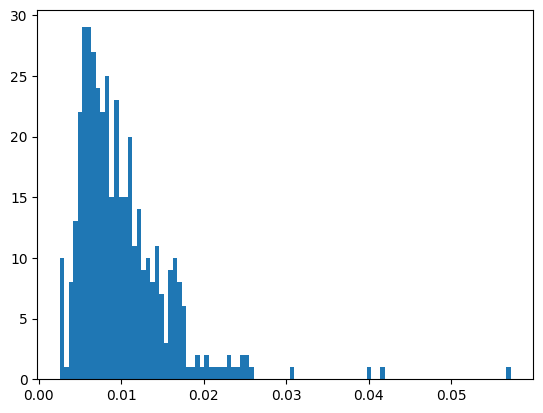

In [6]:
np.random.seed(12345)

newpvals = []
strcirq = str(test_circuit)
newcirqlines = []
for line in strcirq.split('\n'):
  if not ("ERROR" in line or "DEPOLARIZE" in line):
    newcirqlines.append(line)
  else:
    elements = line.split(' ')
    src_err = elements[0]
    qubits = elements[1:]
    # src_err looks like [string](probability). Extract the string and the probability.
    src_prob = src_err.split('(')
    src_prob[1] = float(src_prob[1].split(')')[0])
    src_err = src_prob[0]
    prob_err = src_prob[1]
    sln = np.sqrt(np.log(1.+p_variation**2))
    stride = 1
    if src_prob[0] == "DEPOLARIZE2":
      stride = 2
    for i in range(0, len(qubits), stride):
      new_prob = np.random.lognormal(np.log(prob_err)-sln**2/2, sln)
      newpvals.append(new_prob)
      newcirqlines.append(f"{src_err}({new_prob}) {' '.join(qubits[i:i+stride])}")

for ll in newcirqlines:
  print(ll)

fig, ax = plt.subplots()
ax.hist(newpvals, bins=100)
plt.show()

test_circuit = stim.Circuit("\n".join(newcirqlines))

In [7]:
# Sampling for the dxd circuit
m_sampler = test_circuit.compile_sampler(seed=12345)
d_sampler = test_circuit.compile_detector_sampler(seed=12345)
converter = test_circuit.compile_m2d_converter()
detector_error_model = test_circuit.detector_error_model(decompose_errors=True)

measurements = m_sampler.sample(n_samples, bit_packed=False)
det_evts, flips = converter.convert(measurements=measurements, separate_observables=True, bit_packed=False)
measurements = measurements.astype(binary_t)
det_evts = det_evts.astype(binary_t)
flips = flips.astype(binary_t)

avg_flips = np.sum(flips.reshape(-1,), dtype=np.float32)/flips.shape[0]
print(f"Average flip rate for the full circuit: {avg_flips}")

pymatcher = pymatching.Matching.from_detector_error_model(detector_error_model)
flips_pred_pym = pymatcher.decode_batch(det_evts, bit_packed_predictions=False, bit_packed_shots=False).astype(binary_t).reshape(-1,1)
print(f"PyMatching error rate: {np.sum((flips_pred_pym!=flips))/flips.shape[0]}")

pymatcher = pymatching.Matching.from_detector_error_model(detector_error_model_original)
flips_pred_pym = pymatcher.decode_batch(det_evts, bit_packed_predictions=False, bit_packed_shots=False).astype(binary_t).reshape(-1,1)
print(f"PyMatching error rate from original DEM: {np.sum((flips_pred_pym!=flips))/flips.shape[0]}")

Average flip rate for the full circuit: 0.2483341
PyMatching error rate: 0.0309714
PyMatching error rate from original DEM: 0.0322178


In [8]:
for i, kernel_circuit in enumerate(kernel_circuits):
  print(f"Kernel circuit {i}:")
  print(kernel_circuit)

Kernel circuit 0:
QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(1, 3) 8
QUBIT_COORDS(2, 2) 9
QUBIT_COORDS(3, 3) 10
QUBIT_COORDS(4, 2) 11
QUBIT_COORDS(5, 3) 12
QUBIT_COORDS(6, 2) 13
QUBIT_COORDS(0, 4) 14
QUBIT_COORDS(1, 5) 15
QUBIT_COORDS(2, 4) 16
QUBIT_COORDS(3, 5) 17
QUBIT_COORDS(4, 4) 18
QUBIT_COORDS(5, 5) 19
QUBIT_COORDS(4, 6) 25
R 1 3 5 8 10 12 15 17 19
X_ERROR(0.01) 1 3 5 8 10 12 15 17 19
R 2 9 11 13 14 16 18 25
X_ERROR(0.01) 2 9 11 13 14 16 18 25
TICK
DEPOLARIZE1(0.01) 1 3 5 8 10 12 15 17 19
H 2 11 16 25
DEPOLARIZE1(0.01) 2 11 16 25
TICK
CX 2 3 16 17 11 12 15 14 10 9 19 18
DEPOLARIZE2(0.01) 2 3 16 17 11 12 15 14 10 9 19 18
DEPOLARIZE1(0.01) 13 25
TICK
CX 2 1 16 15 11 10 8 14 3 9 12 18
DEPOLARIZE2(0.01) 2 1 16 15 11 10 8 14 3 9 12 18
DEPOLARIZE1(0.01) 5 13 17 19 25
TICK
CX 16 10 11 5 25 19 8 9 17 18 12 13
DEPOLARIZE2(0.01) 16 10 11 5 25 19 8 9 17 18 12 13
TICK
CX 16 8 11 3 25 17 1 9 10 18 5 13
DEPOLARIZE2(0.01) 16 8 11 3 25 17 1 9

In [9]:
def split_measurements(measurements, d):
  n_measurements = idx_t(measurements.shape[1])
  # Measurements on data qubits come last
  exclude_indices = np.array([-x-1 for x in range(d**2)], dtype=idx_t)
  exclude_indices = exclude_indices + n_measurements
  # Out of all measurements on data qubits, the logical qubit measurements are those on the boundary of the lattice.
  # All other equivalent X_L/Z_L operators can be found through the combination of ancilla measurements and the chosen data qubits giving us the logical qubit.
  exclude_indices_obsL = np.array([-x-1 for x in range(d*(d-1), d**2)], dtype=idx_t)
  exclude_indices_obsL = exclude_indices_obsL + n_measurements
  # From obs_bits, we want to exclude all measurements except those listed in exclude_indices_obsL
  exclude_indices_obs = np.arange(0, n_measurements, 1, dtype=idx_t)
  exclude_indices_obs = np.delete(exclude_indices_obs, exclude_indices_obsL)

  det_bits = measurements
  det_bits = np.delete(det_bits, exclude_indices, axis=1)
  obs_bits = measurements
  obs_bits = np.delete(obs_bits, exclude_indices_obs, axis=1)

  data_bits = measurements[:, exclude_indices]

  # Reverse the order of data_bits because exclude_indices starts from the last data qubit measurement, not the first
  data_bits = np.flip(data_bits, axis=1)

  return det_bits, obs_bits, data_bits


n_measurements = idx_t(measurements.shape[1])
det_bits, obs_bits, data_bits = split_measurements(measurements, d)
print(obs_bits)

[[1 1 1 0 1]
 [0 1 0 0 0]
 [1 1 0 0 0]
 ...
 [1 0 1 1 1]
 [1 1 1 1 0]
 [0 0 1 1 0]]


In [10]:
det_bits_kxk_all, data_bits_kxk_all, obs_bits_kxk_all, kernel_result_translation_map = call_group_det_bits_kxk(det_bits, data_bits_dxd=data_bits)
print(det_bits_kxk_all.shape)
print(data_bits_kxk_all.shape)
print(obs_bits_kxk_all.shape)
print(kernel_result_translation_map.shape)

print(flips[0])
print(det_bits[0])
print(data_bits[0])

kernel_types = get_unique_kernel_types(kernel_size, d)
print(kernel_types)
n_kernels = det_bits_kxk_all.shape[0]
n_kernel_rows = int(np.sqrt(n_kernels))
for k in range(n_kernels):
  print(det_bits_kxk_all[k][0])
  print(data_bits_kxk_all[k][0])
  print(obs_bits_kxk_all[k][0])
  if k % n_kernel_rows == 0:
    print(kernel_result_translation_map[k//n_kernel_rows][0])

(9, 10000000, 16)
(9, 10000000, 9)
(9, 10000000, 3)
(3, 10000000, 2)
[0]
[1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0
 0 1 1 0 0 1 1 1 0 1 0]
[1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0]
[[[1, 1], [0, 8]], [[0, 1], [1, 7]], [[-1, 1], [2, 6]], [[1, 0], [3, 5]], [[0, 0], [4]]]
[1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0]
[1 1 1 1 1 1 1 0 0]
[1 1 1]
[0 0]
[1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0]
[0 1 1 0 1 1 0 0 0]
[1 1 0]
[1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1]
[1 0 1 1 0 1 0 0 1]
[1 0 1]
[1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1]
[1 0 1 1 0 0 1 1 1]
[1 0 1]
[0 0]
[1 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1]
[1 1 0 0 0 0 0 1 0]
[0 1 1]
[1 0 1 0 0 1 0 1 1 0 0 0 0 1 1 1]
[1 0 1 1 0 0 0 0 1]
[1 0 1]
[1 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0]
[1 1 1 1 0 1 0 0 1]
[1 1 1]
[0 0]
[1 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0]
[1 1 1 0 1 0 0 0 0]
[1 1 1]
[0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 0]
[0 1 1 0 0 1 1 0 0]
[1 1 0]


In [11]:
kernel_result_translation_map_f = kernel_result_translation_map[:,:,1:]
kernel_result_translation_map_b = kernel_result_translation_map[:,:,0:-1]
print(kernel_result_translation_map_f.shape)
print(kernel_result_translation_map_b.shape)
kernel_result_translation_det_evts = (kernel_result_translation_map_f!=kernel_result_translation_map_b).astype(binary_t)
print(kernel_result_translation_det_evts.shape)
print(kernel_result_translation_det_evts[:,0,:])
kernel_result_translation_map = np.concatenate((kernel_result_translation_map, kernel_result_translation_det_evts), axis=2)

(3, 10000000, 1)
(3, 10000000, 1)
(3, 10000000, 1)
[[0]
 [0]
 [0]]


In [12]:
det_evts_kxk_all = []
flips_kxk_all = []
converters_kernel = []
for kernel_circuit in kernel_circuits:
  converters_kernel.append(kernel_circuit.compile_m2d_converter())
for k in range(n_kernels):
  measurements_kxk = np.concatenate((det_bits_kxk_all[k], data_bits_kxk_all[k]), axis=1).astype(np.bool_)
  ik = 0
  for i, kernel_type in enumerate(kernel_types):
    if k in kernel_type[1]:
      ik = i
      break
  det_evts_kxk, flips_kxk = converters_kernel[ik].convert(measurements=measurements_kxk, separate_observables=True, bit_packed=False)
  det_evts_kxk_all.append(det_evts_kxk)
  flips_kxk_all.append(flips_kxk)
det_evts_kxk_all = np.array(det_evts_kxk_all, dtype=binary_t)
flips_kxk_all = np.array(flips_kxk_all, dtype=binary_t)
print(det_evts_kxk_all.shape)
print(flips_kxk_all.shape)
del converters_kernel

(9, 10000000, 16)
(9, 10000000, 1)


In [13]:
# Make sure the data type is np.int32 below, not idx_t!
idxs_test, idxs_train = split_data(np.arange(n_samples, dtype=np.int32), test_size = n_test/n_samples, seed = 12345, shuffle = False)

class_bits = flips
features_det_bits = np.swapaxes(det_bits_kxk_all, 0, 1)
features_det_evts = np.swapaxes(det_evts_kxk_all, 0, 1)
features_translation_map = np.swapaxes(kernel_result_translation_map, 0, 1) # Dimensions go as [sample][kernel][cycle bits + detections (n_cycles-1)]
features_translation_map = np.reshape(features_translation_map, (features_translation_map.shape[0], -1))
features_final_det_evts = det_evts[:, -((d**2-1)//2):]

print(features_det_bits.shape)
print(features_det_evts.shape)
print(features_translation_map.shape)
print(features_final_det_evts.shape)

(10000000, 9, 16)
(10000000, 9, 16)
(10000000, 9)
(10000000, 12)


In [14]:
def learning_rate_scheduler(epoch, lr):
  if epoch < 10:
    return lr
  elif epoch < 20:
    return lr * 0.9
  elif epoch < 30:
    return lr * 0.8
  else:
    return lr * 0.65

In [15]:
n_nodes = 100
model_dxd = FullCNNModel(
  observable_type, d, kernel_size, r,
  [n_nodes for _ in range(2)],
  npol=2,
  do_all_data_qubits=False, extended_kernel_output=True, include_det_evts=True,
  include_last_kernel_dets=False, include_last_dets=True, has_nonuniform_response=True, use_translated_kernels=False
)
model_dxd.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_dxd([ features_det_bits[0:1], features_det_evts[0:1], features_translation_map[0:1], features_final_det_evts[0:1] ])
model_dxd.summary()

Number of unique contributions: 13
Total number of fractions: 28
Total number of phases: 62


Model: "full_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cnn_kernel (CNNKernel)          │ ?                      │         1,926 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_kernel_1 (CNNKernel)        │ ?                      │         1,926 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_kernel_2 (CNNKernel)        │ ?                      │         1,926 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_kernel_3 (CNNKernel)        │ ?                      │         1,926 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_kernel_4 (CNNKernel)        │ ?                      │         1,070 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │         2,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,790 (92.93 KB)

 Trainable params: 23,790 (92.93 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
val_split = 0.2
n_epochs = 50
history = model_dxd.fit(
  x=[ features_det_bits[idxs_train], features_det_evts[idxs_train], features_translation_map[idxs_train], features_final_det_evts[idxs_train] ],
  y=class_bits[idxs_train,:],
  batch_size=10000,
  epochs=n_epochs, validation_split=val_split,
  callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)
  ]
)

flips_pred = model_dxd.predict(
  [features_det_bits[idxs_test], features_det_evts[idxs_test], features_translation_map[idxs_test], features_final_det_evts[idxs_test]],
  batch_size=10000
)
print(f"Inaccuracy of the final model on the test data: {(flips[idxs_test]!=(flips_pred>0.5).astype(binary_t)).astype(binary_t).sum()/idxs_test.shape[0]}")

2024-05-30 13:21:12.019718: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 576000000 exceeds 10% of free system memory.
2024-05-30 13:21:14.479468: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 576000000 exceeds 10% of free system memory.


Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8053 - loss: 0.4112

2024-05-30 13:22:42.940071: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 144000000 exceeds 10% of free system memory.
2024-05-30 13:22:43.612871: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 144000000 exceeds 10% of free system memory.


400/400 ━━━━━━━━━━━━━━━━━━━━ 100s 198ms/step - accuracy: 0.8055 - loss: 0.4109 - val_accuracy: 0.9174 - val_loss: 0.1958 - learning_rate: 0.0010
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 81s 202ms/step - accuracy: 0.9278 - loss: 0.1743 - val_accuracy: 0.9461 - val_loss: 0.1365 - learning_rate: 0.0010
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 80s 201ms/step - accuracy: 0.9478 - loss: 0.1317 - val_accuracy: 0.9515 - val_loss: 0.1231 - learning_rate: 0.0010
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 84s 208ms/step - accuracy: 0.9522 - loss: 0.1208 - val_accuracy: 0.9541 - val_loss: 0.1165 - learning_rate: 0.0010
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 82s 205ms/step - accuracy: 0.9547 - loss: 0.1150 - val_accuracy: 0.9556 - val_loss: 0.1126 - learning_rate: 0.0010
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 83s 206ms/step - accuracy: 0.9562 - loss: 0.1114 - val_accuracy: 0.9571 - val_loss: 0.1097 - learning_rate: 0.0010
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 83s 206ms/step - accuracy: 0.9574 - loss

2024-05-30 14:26:23.736820: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 720000000 exceeds 10% of free system memory.


500/500 ━━━━━━━━━━━━━━━━━━━━ 55s 105ms/step
Inaccuracy of the final model on the test data: 0.0369242
